In [89]:
pip install pymupdf4llm langchain-ollama langchain-text-splitters langchain-community faiss-cpu langgraph

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Load Document

In [90]:
import os

documents_dir = "documents/"
target_folders = ["Condotril", "Duobiotic", "Neurofil"]  # nomes dos produtos
documents = {folder: "" for folder in target_folders}  # Inicializa um dicionário para cada produto

for folder in target_folders:
    folder_path = os.path.join(documents_dir, folder)
    
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        for doc_name in os.listdir(folder_path):
            if doc_name.endswith(".txt"):
                print(f"txt encontrado ({doc_name})!")
                file_path = os.path.join(folder_path, doc_name)
                with open(file_path, "r", encoding="utf-8") as doc:
                    content = doc.read()
                    documents[folder] += content + "\n"


txt encontrado (Condotril_bula.txt)!
txt encontrado (Condotril_farmacia.txt)!
txt encontrado (Duobiotic_bula.txt)!
txt encontrado (Duobiotic_farmacia.txt)!
txt encontrado (Neurofil_bula.txt)!
txt encontrado (Neurofil_farmacia.txt)!


In [91]:
documents

{'Condotril': '=D MYPharmã\n\nCONDOTRIL\n\nO QUE É CONDOTRIL?\n\nCONDOTRIL é um suplemento alimentar que contém Sulfato de Glucosamina, Sulfato de Condroitina,\nMSM e outros compostos como a Vitamina C e Manganês. A Vitamina C contribui para a normal for-\nmação de colagénio para o funcionamento normal dos ossos e das cartilagens. O Manganês con-\ntribui para a manutenção de ossos normais e a normal formação de tecidos conjuntivos.\n\nOs suplementos alimentares são géneros alimentícios que se destinam a complementar e/ou a\nsuplementar o regime alimentar normal não devendo ser utilizados como substitutos de um regime\nalimentar variado. Constituem fontes concentradas de determinadas substâncias nutrientes ou\noutras, com efeito nutricional ou fisiológico. É importante um regime alimentar equilibrado e um\nmodo de vida saudável.\n\nIngredientes: Agente de volume: Maltodextrina; Sulfato de glucosamina (marinho); Sulfato\nde condroitina; Agente de volume: Fosfato dicálcico; Cartilagem de 

### Create Chunks

In [92]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=7000, # o chunk_size tem que ser grande para termos o maximo de informaçao sobre um produto num vetor apenas
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)

docs = []
for content in documents.values():
    docs.extend(text_splitter.create_documents([content]))

for _, (product, content) in enumerate(documents.items()):
    num_characters = len(content)
    print(f"Número de caracteres no documento '{product}': {num_characters}")


print("Número de chunks: ", len(docs))

Número de caracteres no documento 'Condotril': 6141
Número de caracteres no documento 'Duobiotic': 4544
Número de caracteres no documento 'Neurofil': 4675
Número de chunks:  3


In [93]:
docs

[Document(metadata={}, page_content='=D MYPharmã\n\nCONDOTRIL\n\nO QUE É CONDOTRIL?\n\nCONDOTRIL é um suplemento alimentar que contém Sulfato de Glucosamina, Sulfato de Condroitina,\nMSM e outros compostos como a Vitamina C e Manganês. A Vitamina C contribui para a normal for-\nmação de colagénio para o funcionamento normal dos ossos e das cartilagens. O Manganês con-\ntribui para a manutenção de ossos normais e a normal formação de tecidos conjuntivos.\n\nOs suplementos alimentares são géneros alimentícios que se destinam a complementar e/ou a\nsuplementar o regime alimentar normal não devendo ser utilizados como substitutos de um regime\nalimentar variado. Constituem fontes concentradas de determinadas substâncias nutrientes ou\noutras, com efeito nutricional ou fisiológico. É importante um regime alimentar equilibrado e um\nmodo de vida saudável.\n\nIngredientes: Agente de volume: Maltodextrina; Sulfato de glucosamina (marinho); Sulfato\nde condroitina; Agente de volume: Fosfato dic

In [94]:
# from langchain_text_splitters import RecursiveCharacterTextSplitter

# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size=1000,
#     chunk_overlap=100,
# )

# documents = text_splitter.create_documents([documents])

### Create VectorStore/Retriever

In [95]:
# ollama needs to be installed
# https://ollama.com/
# https://github.com/ollama/ollama/tree/main/docs
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS

embedding_model = OllamaEmbeddings(
    # model="nomic-embed-text",
    model="llama3.2:1b",
)


vectorstore = FAISS.from_documents(docs, embedding=embedding_model)
vectorstore.save_local(folder_path = 'vectorstore') # save the vectorstore locally

In [96]:
retriever = FAISS.load_local(
    folder_path='vectorstore',
    embeddings=embedding_model,
    allow_dangerous_deserialization=True
    ).as_retriever(search_kwargs={"k" : 2})

In [97]:
question = "Quais são os ingredientes do Condotril"
retriever.invoke(question)

[Document(metadata={}, page_content='=D MYPharmã\n\nCONDOTRIL\n\nO QUE É CONDOTRIL?\n\nCONDOTRIL é um suplemento alimentar que contém Sulfato de Glucosamina, Sulfato de Condroitina,\nMSM e outros compostos como a Vitamina C e Manganês. A Vitamina C contribui para a normal for-\nmação de colagénio para o funcionamento normal dos ossos e das cartilagens. O Manganês con-\ntribui para a manutenção de ossos normais e a normal formação de tecidos conjuntivos.\n\nOs suplementos alimentares são géneros alimentícios que se destinam a complementar e/ou a\nsuplementar o regime alimentar normal não devendo ser utilizados como substitutos de um regime\nalimentar variado. Constituem fontes concentradas de determinadas substâncias nutrientes ou\noutras, com efeito nutricional ou fisiológico. É importante um regime alimentar equilibrado e um\nmodo de vida saudável.\n\nIngredientes: Agente de volume: Maltodextrina; Sulfato de glucosamina (marinho); Sulfato\nde condroitina; Agente de volume: Fosfato dic

In [98]:
from langchain.tools import BaseTool

class ArticleInformation(BaseTool):
    name: str = "ArticleInformation"
    description: str = "This tool is used to answer questions about MyPharma suplements. The input is the original user question"
    
    def _run(self, question):
        retrieved_documents = retriever.invoke(question)
        return [document.page_content for document in retrieved_documents]

### Develop Chatbot workflow (langgraph)

Tools

In [99]:
tools = [ArticleInformation()]
tools_by_name = {tool.name: tool for tool in tools}

AgentState

In [100]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

System Prompt

In [101]:
from langchain_core.messages import SystemMessage

system_prompt =  SystemMessage("""Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. 
                               
If the user asks about Condotril, ignore information about Neurofil and Duobiotic.
If the user asks about Neurofil, ignore information about Condotril and Duobiotic.
If the user asks about Duobiotic, ignore information about Condotril and Neurofil.
  
Your final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.
Do not oversimplify or summarize the answer.

If you are unsure about what tool to use or how to correct an error, you should ask the user for help.""")

Nodes

In [102]:
from typing import Union, Literal
from langchain_ollama import ChatOllama # you can use other chat models from langchain. they need, however, to have function call capabilities (https://python.langchain.com/docs/integrations/chat/)
from langchain_core.messages import ToolMessage, HumanMessage
import json


# ollama needs to be installed
# https://ollama.com/
# https://github.com/ollama/ollama/tree/main/docs
def call_llm(state: AgentState) -> dict[str, Union[list, bool]]:
        """
        Calls the LLM model.
        
        Parameters
        ----------
        state : AgentState
            The state of the agent.
            
        Returns
        -------
        dict[str, Union[list, bool]]
            The updated state after calling the LLM model.
        """
        llm = ChatOllama( model="llama3.2:1b", temperature=0) #instantiates the LLM model
        llm = llm.bind_tools([ArticleInformation()]) #binds the tools to the LLM model
        llm_response = llm.invoke(state['messages']) #calls the LLM model
        
        return {'messages': [llm_response]} #returns the updated state
    
def tool_node(state: AgentState) -> dict[str, Union[list, bool]]:
    '''
    Runs the tool requested in the last AI message (with the tool call).
    
    Parameters
    ----------
    state : AgentState
        The state of the agent.
        
    Returns
    -------
    dict[str, Union[list, bool]]
        The updated state after running the tool.
    '''
    if messages := state.get('messages', []):
        message = messages[-1]
    else:
        raise ValueError('No messages found in input state.')
    
    outputs = []
    
    # tool_call example
    # [{'name': 'ThesisInformation',
    # 'args': {'query': 'What is the...'},
    # 'id': 'call_UwQzgi1QD9uWfBP1r6CWO5ep',
    # 'type': 'tool_call'}]
    
    for tool_call in message.tool_calls:
        tool_result = tools_by_name[tool_call['name']].invoke(
            tool_call['args']
        )
        
        outputs.append(
            ToolMessage(
                content = json.dumps(tool_result),
                name = tool_call['name'],
                tool_call_id = tool_call['id']
            )
        )

        
    return {'messages': outputs}


def route_tools(state: AgentState) -> Literal['tools', '__end__']:
        '''
        To be used in the conditional_edge method when compiling the graph.
        Routes to the tool node if the last message contains a tool call.
        Otherwise, routes to the end.
        
        Parameters
        ----------
        state : ReactState
            The state of the agent.
            
        Returns
        -------
        Literal['tools', '__end__']
            The next node to route to.
        '''        
        if isinstance(state, list):
            ai_message = state[-1]
        elif messages := state.get('messages', []):
            ai_message = messages[-1]
        else:
            raise ValueError(f'No messages found in input state to tool edge: {state}')
        
        if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
            return 'tools'
        return '__end__'

Compile Graph

In [103]:
from langgraph.graph import StateGraph, START

graph = StateGraph(AgentState)
graph.add_node('llm', call_llm)
graph.add_node('tools', tool_node)
graph.add_edge('tools', 'llm')
graph.add_edge(START, 'llm')
graph.add_conditional_edges('llm', route_tools, {'tools': 'tools', '__end__': '__end__'})

#compile graph
graph = graph.compile()

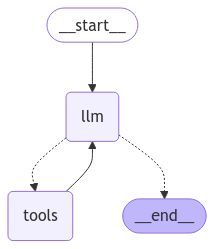

In [104]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [108]:
# Qual é a composição do suplemento alimentar X?
# Quais são os efeitos do suplemento alimentar X? / O que faz o suplemento alimentar X?
# O que acontece se consumir X e tomar o suplemento alimentar Y?
# Como é o processo de toma do suplemento alimentar X?

# Ingredientes
question1 = "Quais são os ingredientes do Condotril?"
question2 = "Quais são os ingredientes do Duobiotic?"
question3 = "Quais são os ingredientes do Neurofil?"

# Benefícios
question4 = "Quais são os benefícios do Condotril?"
question5 = "Quais são os benefícios do Duobiotic?"
question6 = "Quais são os benefícios do Neurofil?"

# Efeitos
question7 = "Quais são os efeitos do Condotril?"
question8 = "Quais são os efeitos do Duobiotic?"
question9 = "Quais são os efeitos do Nueurofil?"

# Processo de toma
question10 = "Qual é o processo de toma do Condotril?"
question11 = "Qual é o processo de toma do Duobiotic?"
question12 = "Qual é o processo de toma do Neurofil?"

# Condições de armazenamento
question13 = "Quais são as condições de armazenamento do Condotril?"
question14 = "Quais são as condições de armazenamento do Duobiotic?"
question15 = "Quais são as condições de armazenamento do Neurofil?"

# Precaussões
question16 = "Em que casos não se pode tomar Condotril?"
question17 = "Em que casos não se pode tomar Duobiotic?"
question18 = "Em que casos não se pode tomar Neurofil?"

In [106]:
response1 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question1)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}),
              HumanMessage(content='Quais são os ingredientes do Condotril?', additional

In [107]:
response2 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question2)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Quais são

In [109]:
response3 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question3)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Quais são

In [110]:
response4 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question4)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Quais são

In [111]:
response5 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question5)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Quais são

In [112]:
response6 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question6)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Quais são

In [113]:
response7 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question7)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Quais são

In [114]:
response8 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question8)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Quais são

In [115]:
response9 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question9)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Quais são

In [116]:
response10 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question10)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Qual é o 

In [117]:
response11 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question11)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Qual é o 

In [118]:
response12 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question12)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Qual é o 

In [119]:
response13 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question13)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Quais são

In [120]:
response14 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question14)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Quais são

In [121]:
response15 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question15)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Quais são

In [122]:
response16 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question16)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Em que ca

In [123]:
response17 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question17)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Em que ca

In [124]:
response18 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question18)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n                               \nIf the user asks about Condotril, ignore information about Neurofil and Duobiotic.\nIf the user asks about Neurofil, ignore information about Condotril and Duobiotic.\nIf the user asks about Duobiotic, ignore information about Condotril and Neurofil.\n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='955cf395-af6b-4aeb-8c8e-aaa3eb700a35'),
              HumanMessage(content='Em que ca

In [125]:
print("Pergunta: ", question1)
print("Resposta: ", response1['messages'][-1].content)

Pergunta:  Quais são os ingredientes do Condotril?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para melhorar a resistência e flexibilidade das articulações, reduzir o movimento das articulações e ajudar na regeneração das cartilagens.


In [126]:
print("Pergunta: ", question2)
print("Resposta: ", response2['messages'][-1].content)

Pergunta:  Quais são os ingredientes do Duobiotic?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para melhorar a resistência e flexibilidade das articulações, reduzir o movimento das articulações e ajudar na regeneração das cartilagens.


In [127]:
print("Pergunta: ", question3)
print("Resposta: ", response3['messages'][-1].content)

Pergunta:  Quais são os ingredientes do Neurofil?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para auxiliar na manutenção e regeneração das cartilagens, reduzir o movimento das articulações e ajudar a neutralizar os radicais livres que destroem as cartilagens.


In [128]:
print("Pergunta: ", question4)
print("Resposta: ", response4['messages'][-1].content)

Pergunta:  Quais são os benefícios do Condotril?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para melhorar a resistência e flexibilidade das articulações, reduzir o movimento das articulações e ajudar na regeneração das cartilagens.


In [129]:
print("Pergunta: ", question5)
print("Resposta: ", response5['messages'][-1].content)

Pergunta:  Quais são os benefícios do Duobiotic?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para melhorar a resistência e flexibilidade das articulações, reduzir o movimento das articulações e ajudar na regeneração das cartilagens.


In [130]:
print("Pergunta: ", question6)
print("Resposta: ", response6['messages'][-1].content)

Pergunta:  Quais são os benefícios do Neurofil?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para auxiliar na manutenção e regeneração das cartilagens, reduzir o movimento das articulações e ajudar a neutralizar os radicais livres que destroem as cartilagens.


In [131]:
print("Pergunta: ", question7)
print("Resposta: ", response7['messages'][-1].content)

Pergunta:  Quais são os efeitos do Condotril?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para melhorar a resistência e flexibilidade das articulações, reduzir o movimento das articulações e ajudar na regeneração das cartilagens.


In [132]:
print("Pergunta: ", question8)
print("Resposta: ", response8['messages'][-1].content)

Pergunta:  Quais são os efeitos do Duobiotic?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para melhorar a resistência e flexibilidade das articulações, reduzir o movimento das articulações e ajudar na regeneração das cartilagens.


In [133]:
print("Pergunta: ", question9)
print("Resposta: ", response9['messages'][-1].content)

Pergunta:  Quais são os efeitos do Nueurofil?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para auxiliar na manutenção e regeneração das cartilagens, reduzir o movimento das articulações e ajudar a neutralizar os radicais livres que destroem as cartilagens.


In [134]:
print("Pergunta: ", question10)
print("Resposta: ", response10['messages'][-1].content)

Pergunta:  Qual é o processo de toma do Condotril?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para melhorar a resistência e flexibilidade das articulações, reduzir o movimento das articulações e ajudar na regeneração das cartilagens.


In [135]:
print("Pergunta: ", question11)
print("Resposta: ", response11['messages'][-1].content)

Pergunta:  Qual é o processo de toma do Duobiotic?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para melhorar a resistência e flexibilidade das articulações, reduzir o movimento das articulações e ajudar na regeneração das cartilagens.


In [136]:
print("Pergunta: ", question12)
print("Resposta: ", response12['messages'][-1].content)

Pergunta:  Qual é o processo de toma do Neurofil?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para auxiliar na manutenção e regeneração das cartilagens, reduzir o movimento das articulações e ajudar a neutralizar os radicais livres que destroem as cartilagens.


In [137]:
print("Pergunta: ", question13)
print("Resposta: ", response13['messages'][-1].content)

Pergunta:  Quais são as condições de armazenamento do Condotril?
Resposta:  Para saber mais sobre este produto, por favor consulte o folheto de instruções do medicamento.


In [138]:
print("Pergunta: ", question14)
print("Resposta: ", response14['messages'][-1].content)

Pergunta:  Quais são as condições de armazenamento do Duobiotic?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para melhorar a resistência e flexibilidade das articulações, reduzir o movimento das articulações e ajudar na regeneração das cartilagens.


In [139]:
print("Pergunta: ", question15)
print("Resposta: ", response15['messages'][-1].content)

Pergunta:  Quais são as condições de armazenamento do Neurofil?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para melhorar a resistência e flexibilidade das articulações, reduzir o movimento das articulações e ajudar na regeneração das cartilagens.


In [140]:
print("Pergunta: ", question16)
print("Resposta: ", response16['messages'][-1].content)

Pergunta:  Em que casos não se pode tomar Condotril?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para melhorar a resistência e flexibilidade das articulações, reduzir o movimento das articulações e ajudar na regeneração das cartilagens.


In [141]:
print("Pergunta: ", question17)
print("Resposta: ", response17['messages'][-1].content)

Pergunta:  Em que casos não se pode tomar Duobiotic?
Resposta:  O Condrotril é um suplemento alimentar que contém sulfato de condroitina, sulfato de glucosamina, cartilagem de tubarão, ácido hialurônico e harpagófito. Ele é indicado para melhorar a resistência e flexibilidade das articulações, reduzir o movimento das articulações e ajudar na regeneração das cartilagens.


In [142]:
print("Pergunta: ", question18)
print("Resposta: ", response18['messages'][-1].content)

Pergunta:  Em que casos não se pode tomar Neurofil?
Resposta:  O produto em questão é o Duobiotic Soluções Orais, uma suplementação alimentar que combina prebióticos e probióticos para promover a saúde da flora intestinal. Os prebióticos ajudam a nutrir as bactérias benéficas presentes na flora intestinal, enquanto os probióticos estimulam o crescimento dessas bactérias e melhoram a atividade digestiva.

Os principais componentes do Duobiotic Soluções Orais incluem:

* Lactobacilos: microorganismos que ajudam a reequilibrar a flora intestinal
* Bifidobacterias: microorganismos que promovem a sinterese de vitaminas e enzimas digestivas
* Prebióticos: microorganismos vivos selecionados que colonizam a flora intestinal e restabelecem o seu equilíbrio

Esses prebióticos são microorganismos que não são digeridos pelos humanos, mas sim são absorvidos pelo intestino e utilizados como fonte de nutrientes para as bactérias benéficas presentes na flora intestinal. Isso ajuda a promover o crescim